# G2M insight for Cab Investment firm

We have been provided with 4 individuals datasets:


1. **Cab_Data.csv** this file includes details of transactions for 2 cab companies
2. **Customer_ID.csv** this is a mapping table that contains a unique identifier which links the customer’s demographic details,
3. **Transaction_ID.csv** this is a mapping table that contains transaction to customer mapping and payment mode,
4. **City.csv** this file contains list of US cities, their population and number of cab users


The main objective of this project is to provide actionable insights to help XYZ firm in identifying the right company for making investment.

Areas to investigate:
* Which company has maximum cab users at a particular time period?
* Does margin proportionally increase with increase in number of customers?
* What are the attributes of the customer segments?

Hypothesis to test:
* Is there any seasonality in number of customers using the cab service?
* Is there any seasonality in profit per cab company?
* Do users prefer a particular company?



In [1]:
# Importings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# Dataset loadings
cab_data = pd.read_csv('DataSets/Cab_Data.csv')
city_df = pd.read_csv('DataSets/City.csv')
Customer_ID_df = pd.read_csv('DataSets/Customer_ID.csv')
Transaction_ID_df = pd.read_csv('DataSets/Transaction_ID.csv')
us_holidays = pd.read_csv('DataSets/US_Holidays_Day.txt', header=None, usecols=[1,2], names=['Date', 'Holiday'], parse_dates=['Date'])

## EDA

### 1. Cab_Data dataset

In [3]:
cab_data.sort_values(by=['Date of Travel'], inplace=True)
cab_data.reset_index(drop=True, inplace=True)

In [4]:
cab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359392 entries, 0 to 359391
Data columns (total 7 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Transaction ID  359392 non-null  int64  
 1   Date of Travel  359392 non-null  int64  
 2   Company         359392 non-null  object 
 3   City            359392 non-null  object 
 4   KM Travelled    359392 non-null  float64
 5   Price Charged   359392 non-null  float64
 6   Cost of Trip    359392 non-null  float64
dtypes: float64(3), int64(2), object(2)
memory usage: 19.2+ MB


In [5]:
cab_data.isnull().sum()

Transaction ID    0
Date of Travel    0
Company           0
City              0
KM Travelled      0
Price Charged     0
Cost of Trip      0
dtype: int64

The cab_data dataframe have 7 features and 359392 rows with no NaN values.

In [6]:
cab_data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
0,10001340,42371,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640
1,10000640,42371,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640
2,10000635,42371,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752
3,10001001,42371,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960
4,10000171,42371,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840


In [7]:
cab_data.tail()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip
359387,10435011,43465,Yellow Cab,MIAMI FL,21.20,319.09,300.1920
359388,10433309,43465,Pink Cab,LOS ANGELES CA,10.70,128.00,119.8400
359389,10435915,43465,Yellow Cab,SACRAMENTO CA,27.14,374.95,377.7888
359390,10439845,43465,Yellow Cab,TUCSON AZ,27.16,513.62,361.7712
359391,10438644,43465,Yellow Cab,NEW YORK NY,3.45,77.13,49.6800


It is observed that the column 'Date of Travel' has the Unix timestamp. So it will be chaged to YY-MM-DD format.

In [8]:
datetime.date(2016, 1, 31)-datetime.timedelta(days=42371)

datetime.date(1900, 1, 28)

In [9]:
datetime.date(2018, 12, 31)-datetime.timedelta(days=43465)

datetime.date(1899, 12, 30)

In [10]:
datetime.date(1899, 12, 30) + datetime.timedelta(days=42371)

datetime.date(2016, 1, 2)

In [11]:
datetime.date(1899, 12, 30) + datetime.timedelta(days=43465)

datetime.date(2018, 12, 31)

If we take 1899-12-30 as the begining of unix time, then the cab_data dataset has the following timestamp range: from 2016-1-2 to 2018-12-31.

In [12]:
#Changing timestamps format

timestamps = cab_data['Date of Travel'].to_list()

dts = []

for ts in timestamps:
    dts.append((datetime.date(1899,12,30) + datetime.timedelta(days=ts)).strftime("%Y-%m-%d"))

In [13]:
cab_data['Date'] = pd.to_datetime(dts)

In [14]:
#Checking new column
cab_data.head()

,Transaction ID,Date of Travel,Company,City,KM Travelled,Price Charged,Cost of Trip,Date
0,10001340,42371,Yellow Cab,WASHINGTON DC,10.20,202.54,135.8640,2016-01-02
1,10000640,42371,Yellow Cab,CHICAGO IL,15.60,374.66,209.6640,2016-01-02
2,10000635,42371,Yellow Cab,CHICAGO IL,25.08,532.83,337.0752,2016-01-02
3,10001001,42371,Yellow Cab,NEW YORK NY,46.80,1391.91,595.2960,2016-01-02
4,10000171,42371,Pink Cab,SAN DIEGO CA,14.28,269.15,147.0840,2016-01-02


### 2. City dataset

In [15]:
city_df.head()

,City,Population,Users
0,NEW YORK NY,"8,405,837","302,149"
1,CHICAGO IL,"1,955,130","164,468"
2,LOS ANGELES CA,"1,595,037","144,132"
3,MIAMI FL,"1,339,155","17,675"
4,SILICON VALLEY,"1,177,609","27,247"


In [16]:
city_df.replace(',', '', regex=True, inplace=True)

In [17]:
c = ['Population', 'Users']
city_df[c] = city_df[c].apply(pd.to_numeric,errors='coerce')

In [18]:
city_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   City        20 non-null     object
 1   Population  20 non-null     int64 
 2   Users       20 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 608.0+ bytes


### 3. Customer_ID dataset

In [19]:
Customer_ID_df.head()

,Customer ID,Gender,Age,Income (USD/Month)
0,29290,Male,28,10813
1,27703,Male,27,9237
2,28712,Male,53,11242
3,28020,Male,23,23327
4,27182,Male,33,8536


In [20]:
Customer_ID_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49171 entries, 0 to 49170
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Customer ID         49171 non-null  int64 
 1   Gender              49171 non-null  object
 2   Age                 49171 non-null  int64 
 3   Income (USD/Month)  49171 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB


### 4. Transaction_ID dataset

In [21]:
Transaction_ID_df.head()

,Transaction ID,Customer ID,Payment_Mode
0,10000011,29290,Card
1,10000012,27703,Card
2,10000013,28712,Cash
3,10000014,28020,Cash
4,10000015,27182,Card


In [22]:
Transaction_ID_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440098 entries, 0 to 440097
Data columns (total 3 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   Transaction ID  440098 non-null  int64 
 1   Customer ID     440098 non-null  int64 
 2   Payment_Mode    440098 non-null  object
dtypes: int64(2), object(1)
memory usage: 10.1+ MB


## 5. US Holidays dataset

In [23]:
us_holidays.head()

,Date,Holiday
0,2012-01-02,New Year Day
1,2012-01-16,Martin Luther King Jr. Day
2,2012-02-20,Presidents Day (Washingtons Birthday)
3,2012-05-28,Memorial Day
4,2012-07-04,Independence Day


In [24]:
us_holidays.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90 entries, 0 to 89
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Date     90 non-null     datetime64[ns]
 1   Holiday  90 non-null     object        
dtypes: datetime64[ns](1), object(1)
memory usage: 1.5+ KB


In [25]:
holidays_names= list(us_holidays.Holiday.unique())

### Dataset Merging

In [26]:
df1 = pd.merge(Transaction_ID_df, Customer_ID_df, on='Customer ID')

In [27]:
df2 = pd.merge(cab_data, df1, on='Transaction ID')

In [28]:
df3 = pd.merge(us_holidays, df2, on='Date', how='right')

In [29]:
df = pd.merge(city_df, df3, on='City')

In [30]:
to_drop = ['Date of Travel', 'Transaction ID', 'Customer ID']

In [31]:
df.drop(to_drop, axis=1, inplace=True)

### Profit calculation:

In [32]:
df['Profit'] = df['Price Charged'] - df['Cost of Trip']

In [33]:
df['Margin'] = ((df['Price Charged'] - df['Cost of Trip']) / df['Price Charged']) * 100

In [34]:
df['Markup'] = ((df['Price Charged'] - df['Cost of Trip']) / df['Cost of Trip']) * 100

### Final dataframe:

In [35]:
df.head()

,City,Population,Users,Date,Holiday,Company,KM Travelled,Price Charged,Cost of Trip,Payment_Mode,Gender,Age,Income (USD/Month),Profit,Margin,Markup
0,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,46.80,1391.91,595.2960,Card,Male,40,11462,796.6140,57.231718,133.818134
1,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,37.12,1238.35,507.8016,Card,Male,34,2589,730.5484,58.993693,143.864927
2,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,38.88,1211.78,517.8816,Cash,Male,45,12186,693.8984,57.262737,133.987846
3,NEW YORK NY,8405837,302149,2016-01-02,NaN,Pink Cab,2.10,37.18,21.4200,Cash,Male,28,15285,15.7600,42.388381,73.576097
4,NEW YORK NY,8405837,302149,2016-01-02,NaN,Pink Cab,32.64,498.60,349.2480,Card,Male,52,15974,149.3520,29.954272,42.763881


In [36]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 359392 entries, 0 to 359391
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   City                359392 non-null  object        
 1   Population          359392 non-null  int64         
 2   Users               359392 non-null  int64         
 3   Date                359392 non-null  datetime64[ns]
 4   Holiday             7577 non-null    object        
 5   Company             359392 non-null  object        
 6   KM Travelled        359392 non-null  float64       
 7   Price Charged       359392 non-null  float64       
 8   Cost of Trip        359392 non-null  float64       
 9   Payment_Mode        359392 non-null  object        
 10  Gender              359392 non-null  object        
 11  Age                 359392 non-null  int64         
 12  Income (USD/Month)  359392 non-null  int64         
 13  Profit              359392 no

In [37]:
df.City.unique()

array(['NEW YORK NY', 'CHICAGO IL', 'LOS ANGELES CA', 'MIAMI FL',
       'SILICON VALLEY', 'ORANGE COUNTY', 'SAN DIEGO CA', 'PHOENIX AZ',
       'DALLAS TX', 'ATLANTA GA', 'DENVER CO', 'AUSTIN TX', 'SEATTLE WA',
       'TUCSON AZ', 'SACRAMENTO CA', 'PITTSBURGH PA', 'WASHINGTON DC',
       'NASHVILLE TN', 'BOSTON MA'], dtype=object)

In [38]:
df.Gender.unique()

array(['Male', 'Female'], dtype=object)

In [39]:
df.Company.unique()

array(['Yellow Cab', 'Pink Cab'], dtype=object)

In [40]:
df.Payment_Mode.unique()

array(['Card', 'Cash'], dtype=object)

In [41]:
df.describe()

,Population,Users,KM Travelled,Price Charged,Cost of Trip,Age,Income (USD/Month),Profit,Margin,Markup
count,3.593920e+05,359392.000000,359392.000000,359392.000000,359392.000000,359392.000000,359392.000000,359392.000000,359392.000000,359392.000000
mean,3.132198e+06,158365.582267,22.567254,423.443311,286.190113,35.336705,15048.822937,137.253198,27.128413,47.523115
std,3.315194e+06,100850.051020,12.233526,274.378911,157.993661,12.594234,7969.409482,160.311840,18.550100,42.571507
min,2.489680e+05,3643.000000,1.900000,15.600000,19.000000,18.000000,2000.000000,-220.060000,-69.301505,-40.933780
25%,6.712380e+05,80021.000000,12.000000,206.437500,151.200000,25.000000,8424.000000,28.012000,13.855876,16.084529
50%,1.595037e+06,144132.000000,22.440000,386.360000,282.480000,33.000000,14685.000000,81.962000,26.430302,35.925527
75%,8.405837e+06,302149.000000,32.960000,583.660000,413.683200,42.000000,21035.000000,190.030000,41.611989,71.268038
max,8.405837e+06,302149.000000,48.000000,2048.030000,691.200000,65.000000,35000.000000,1463.966000,76.202636,320.214607


In [42]:
df.Company.value_counts()

Yellow Cab    274681
Pink Cab       84711
Name: Company, dtype: int64

In [43]:
#df.to_csv('G2M_Case_study_finalds.csv')

## Data Visualization

### Users characterization

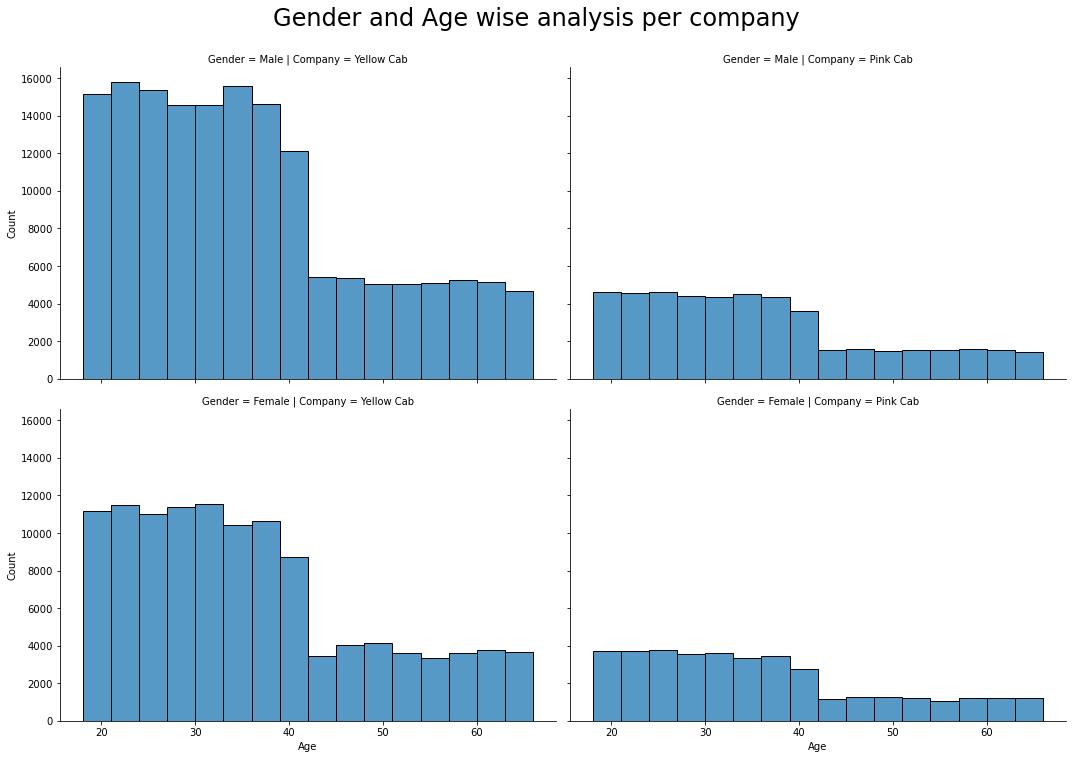

In [44]:
#Gender and Age analysis for each company
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 5.7,4.27

g = sns.displot(x='Age', data=df, binwidth=3, col='Company', row='Gender',aspect=1.5)

g.fig.suptitle('Gender and Age wise analysis per company', y=1.05, fontsize=24, fontdict={"weight": "bold"})

plt.show()

From this plot we can infer that the Age and Gender distribution for both Companies is comparable. For both companies, the majority of their users are between 18 and 40 years old, most of them men. The difference in gender is best observed in the Yellow Cab company.

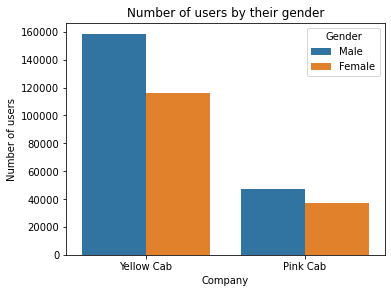

In [45]:
#Number of users by gender
sns.countplot(x='Company', data=df, hue='Gender')
plt.ylabel('Number of users')
plt.title('Number of users by their gender')
plt.show()

For both companies the majority of their users are men.

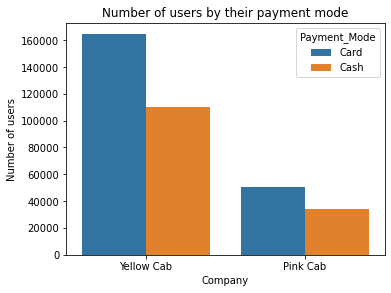

In [46]:
sns.countplot(x='Company', data=df, hue='Payment_Mode')
plt.ylabel('Number of users')
plt.xlabel('Company')
plt.title('Number of users by their payment mode')
plt.show()

For both companies the payment mode most used is card.

In [47]:
#Data transformation for ploting number of users per city
df_plot = df.groupby(['Company', 'City']).size().reset_index().pivot(columns='Company', index='City', values=0)

In [48]:
df_plot['Total'] = df_plot['Yellow Cab'] + df_plot['Pink Cab']
df_plot_sorted = df_plot.sort_values(by='Total', ascending=True)
df_plot_sorted

Company,Pink Cab,Yellow Cab,Total
City,,,
PITTSBURGH PA,682,631,1313
TUCSON AZ,799,1132,1931
PHOENIX AZ,864,1200,2064
SACRAMENTO CA,1334,1033,2367
NASHVILLE TN,1841,1169,3010
DENVER CO,1394,2431,3825
ORANGE COUNTY,1513,2469,3982
AUSTIN TX,1868,3028,4896
MIAMI FL,2002,4452,6454


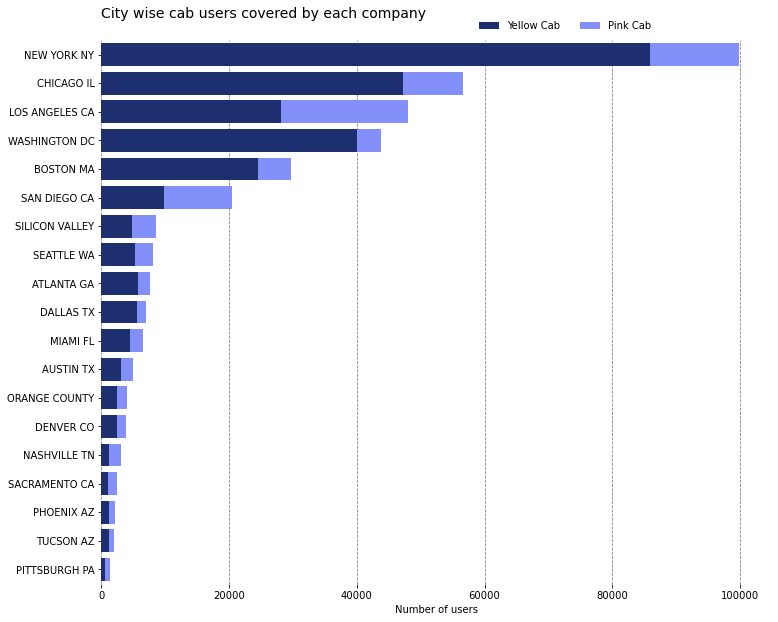

In [49]:
companies = ['Yellow Cab', 'Pink Cab']
colors = ['#1D2F6F', '#8390FA']
labels = ['Yellow Cab', 'Pink Cab']

fig, ax = plt.subplots(1, figsize=(12, 10))

left = len(df_plot_sorted) * [0]
for idx, name in enumerate(companies):
    plt.barh(df_plot_sorted.index, df_plot_sorted[name], left = left, color=colors[idx])
    left = left + df_plot_sorted[name]
    
plt.title('City wise cab users covered by each company\n', loc='left', color='black', fontsize=14)
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Number of users')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.show()

The Yellow cab company dominates the market over the Pink cab company in New York. Only in Los Angeles a comparable aumount of users is found between both companies.

### Income and Profit analysis

In [50]:
income_analysis = df[['Company', 'Income (USD/Month)', 'Profit']]

In [51]:
income_analysis.head()

,Company,Income (USD/Month),Profit
0,Yellow Cab,11462,796.6140
1,Yellow Cab,2589,730.5484
2,Yellow Cab,12186,693.8984
3,Pink Cab,15285,15.7600
4,Pink Cab,15974,149.3520


In [52]:
income_analysis.describe()

,Income (USD/Month),Profit
count,359392.000000,359392.000000
mean,15048.822937,137.253198
std,7969.409482,160.311840
min,2000.000000,-220.060000
25%,8424.000000,28.012000
50%,14685.000000,81.962000
75%,21035.000000,190.030000
max,35000.000000,1463.966000


In [53]:
bins_income = [2000.0, 10000.0, 20000.0, 30000.0, 35000.0]
names_income = ["2000-10000", "10000-20000", "20000-30000", "30000-35000"]

In [54]:
income_analysis["Income (USD/Month)"] = pd.cut(income_analysis['Income (USD/Month)'], bins_income, labels=names_income)

<ipython-input-54-e8e586ac9f81>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_analysis["Income (USD/Month)"] = pd.cut(income_analysis['Income (USD/Month)'], bins_income, labels=names_income)


In [55]:
income_analysis.head()

,Company,Income (USD/Month),Profit
0,Yellow Cab,10000-20000,796.6140
1,Yellow Cab,2000-10000,730.5484
2,Yellow Cab,10000-20000,693.8984
3,Pink Cab,10000-20000,15.7600
4,Pink Cab,10000-20000,149.3520


In [56]:
agg_income = income_analysis.groupby(['Company', 'Income (USD/Month)'])['Profit'].sum().unstack()

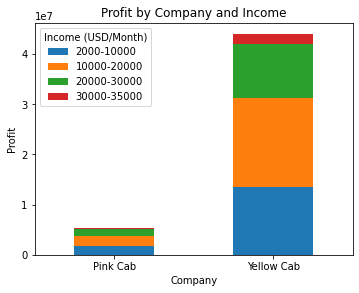

In [57]:
agg_income.plot(kind='bar', stacked=True)
plt.xticks(rotation=0, ha='center')
plt.ylabel('Profit')
plt.title('Profit by Company and Income')
plt.show()

Middle and upper-middle class users contribute strongly to the profit of both companies.

### Profit and Age analysis

In [58]:
#Age-profit analysis
age_analysis = df[['Company', 'Age', 'Profit']]

In [59]:
bins_age = [18, 25, 35, 45, 60, 100]
names_age = ["18-25", "26-35", "36-45", "46-60", ">60"]

In [60]:
age_analysis["Age"] = pd.cut(age_analysis['Age'], bins_age, labels=names_age)

<ipython-input-60-13024ca7e824>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  age_analysis["Age"] = pd.cut(age_analysis['Age'], bins_age, labels=names_age)


In [61]:
agg_age = age_analysis.groupby(['Company', 'Age'])['Profit'].sum().unstack()

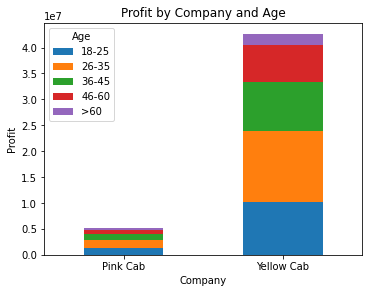

In [62]:
agg_age.plot(kind='bar', stacked=True)
plt.xticks(rotation=0, ha='center')
plt.ylabel('Profit')
plt.title('Profit by Company and Age')
plt.show()

Young users and young adults contribute strongly to the profitability of both companies.

### Profit analysis

In [63]:
df_ts = df.set_index('Date')

In [64]:
profit = df_ts[['Profit', 'Company']]

In [65]:
yellow_cab_profit = profit[profit['Company'] == 'Yellow Cab']
pink_cab_profit = profit[profit['Company'] == 'Pink Cab']

In [66]:
yellow_cab_profit_monthly = yellow_cab_profit.resample('M').mean()
pink_cab_profit_monthly = pink_cab_profit.resample('M').mean()

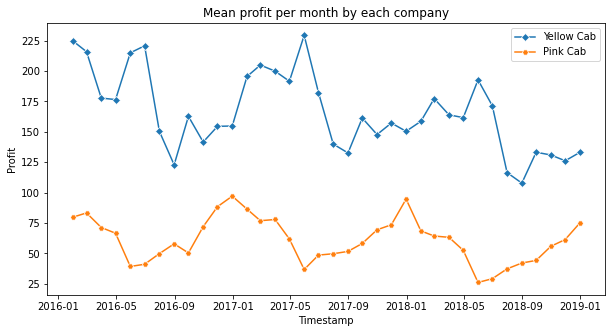

In [67]:
plt.figure(figsize = (10,5))
sns.lineplot(x=yellow_cab_profit_monthly.index, y='Profit', data=yellow_cab_profit_monthly, marker='D')
sns.lineplot(x=pink_cab_profit_monthly.index, y='Profit', data=pink_cab_profit_monthly, marker='H')
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.title('Mean profit per month by each company')
plt.xlabel('Timestamp')
plt.show()

A clear seasonality is observed. The presence of of variations that occur monthly can be observed for both companies. In the case of the Yellow Cab company, a higher gain is observed around the month of May for each year. While their lowest profit is around the month of September. On the other hand, in the case of the Pink Cab company, a higher profit is observed around the month of January for each year. While their lowest profit is around the month of May.

In [68]:
yellow_cab_profit_yearly = yellow_cab_profit.resample('Y').mean()
pink_cab_profit_yearly = pink_cab_profit.resample('Y').mean()

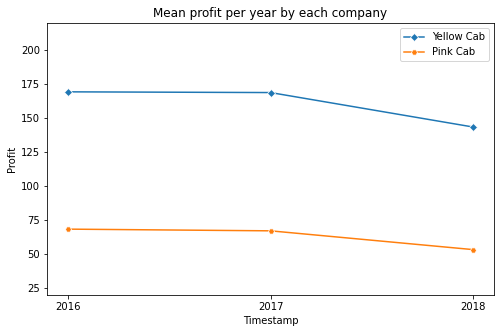

In [69]:
plt.figure(figsize = (8,5))
sns.lineplot(x=yellow_cab_profit_yearly.index.strftime('%Y'), y='Profit', data=yellow_cab_profit_yearly, marker='D')
sns.lineplot(x=pink_cab_profit_yearly.index.strftime('%Y'), y='Profit', data=pink_cab_profit_yearly, marker='H')
plt.legend(['Yellow Cab', 'Pink Cab'])
plt.title('Mean profit per year by each company')
plt.xlabel('Timestamp')
plt.ylim([20, 220])
plt.show()

An analysis of the annual profit for each company shows a downward trend. This trend is much more marked for the Yellow Cab company.

In [133]:
df.head()

,City,Population,Users,Date,Holiday,Company,KM Travelled,Price Charged,Cost of Trip,Payment_Mode,Gender,Age,Income (USD/Month),Profit,Margin,Markup
0,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,46.80,1391.91,595.2960,Card,Male,40,11462,796.6140,57.231718,133.818134
1,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,37.12,1238.35,507.8016,Card,Male,34,2589,730.5484,58.993693,143.864927
2,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,38.88,1211.78,517.8816,Cash,Male,45,12186,693.8984,57.262737,133.987846
3,NEW YORK NY,8405837,302149,2016-01-02,NaN,Pink Cab,2.10,37.18,21.4200,Cash,Male,28,15285,15.7600,42.388381,73.576097
4,NEW YORK NY,8405837,302149,2016-01-02,NaN,Pink Cab,32.64,498.60,349.2480,Card,Male,52,15974,149.3520,29.954272,42.763881


In [157]:
#Profit and Cost per Ride
profit2 = df[['Date','Company', 'Cost of Trip', 'Profit']]

In [ ]:
profit2_month = profit2.resample('M', on='Date')

### Gender contribution in profit

In [70]:
#Gender contribution in profit
profit_gender = df_ts[['Profit', 'Company', 'Gender']]
profit_gender_grouped = profit_gender.groupby([pd.Grouper(freq="A"), 'Company', 'Gender'])['Profit'].agg(['mean'])

In [71]:
profit_gender_grouped.reset_index(inplace=True)

In [72]:
profit_gender_grouped.rename(columns={'mean':'Mean Profit'}, inplace=True)
profit_gender_grouped.Date = profit_gender_grouped.Date.apply(lambda x : x.year)

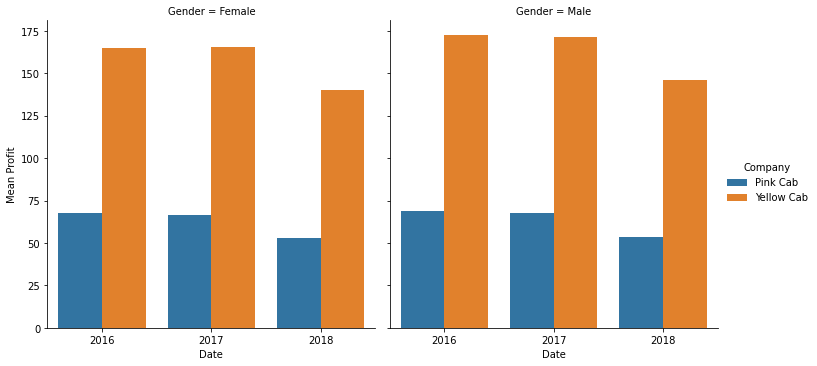

In [73]:
sns.catplot(x='Date', y='Mean Profit', data=profit_gender_grouped, hue='Company', col='Gender', kind='bar')

There is almost equal distribution of gender in the profit.

In [74]:
df.head()

,City,Population,Users,Date,Holiday,Company,KM Travelled,Price Charged,Cost of Trip,Payment_Mode,Gender,Age,Income (USD/Month),Profit,Margin,Markup
0,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,46.80,1391.91,595.2960,Card,Male,40,11462,796.6140,57.231718,133.818134
1,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,37.12,1238.35,507.8016,Card,Male,34,2589,730.5484,58.993693,143.864927
2,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,38.88,1211.78,517.8816,Cash,Male,45,12186,693.8984,57.262737,133.987846
3,NEW YORK NY,8405837,302149,2016-01-02,NaN,Pink Cab,2.10,37.18,21.4200,Cash,Male,28,15285,15.7600,42.388381,73.576097
4,NEW YORK NY,8405837,302149,2016-01-02,NaN,Pink Cab,32.64,498.60,349.2480,Card,Male,52,15974,149.3520,29.954272,42.763881


In [75]:
corr = df.drop(['City', 'Holiday', 'Payment_Mode', 'Gender', 'Age', 'Income (USD/Month)'], axis=1).corr()
corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,Population,Users,KM Travelled,Price Charged,Cost of Trip,Profit,Margin,Markup
Population,1.00,0.92,-0.00,0.33,0.02,0.54,0.64,0.69
Users,0.92,1.00,-0.00,0.28,0.02,0.46,0.53,0.58
KM Travelled,-0.00,-0.00,1.00,0.84,0.98,0.46,0.00,-0.00
Price Charged,0.33,0.28,0.84,1.00,0.86,0.86,0.44,0.46
Cost of Trip,0.02,0.02,0.98,0.86,1.00,0.49,0.02,0.02
Profit,0.54,0.46,0.46,0.86,0.49,1.00,0.74,0.78
Margin,0.64,0.53,0.00,0.44,0.02,0.74,1.00,0.95
Markup,0.69,0.58,-0.00,0.46,0.02,0.78,0.95,1.00


86 % of the profit is explained by price charged

## Rides analysis

In [76]:
number_rides = df.Company.value_counts()
profit_per_company = df.groupby('Company')['Profit'].sum()

In [77]:
number_rides

Yellow Cab    274681
Pink Cab       84711
Name: Company, dtype: int64

In [78]:
profit_per_company

Company
Pink Cab      5.307328e+06
Yellow Cab    4.402037e+07
Name: Profit, dtype: float64

In [79]:
yellow_cab_profit_per_rides = profit_per_company['Yellow Cab'] / number_rides['Yellow Cab']  
pink_cab_profit_per_rides = profit_per_company['Pink Cab'] / number_rides['Pink Cab']

In [80]:
yellow_cab_profit_per_rides

160.2599858410376

In [81]:
pink_cab_profit_per_rides

62.65217410961903

In [82]:
df_date = df.set_index('Date')

In [83]:
number_rides_per_year = df_date.groupby([pd.Grouper(freq="A"), "Company"])['City'].agg(['count'])

In [84]:
number_rides_per_year.reset_index(inplace=True)

In [85]:
number_rides_per_year.rename(columns={'count':'Total Rides'}, inplace=True)
number_rides_per_year.Date = number_rides_per_year.Date.apply(lambda x : x.year)

<Figure size 576x504 with 0 Axes>

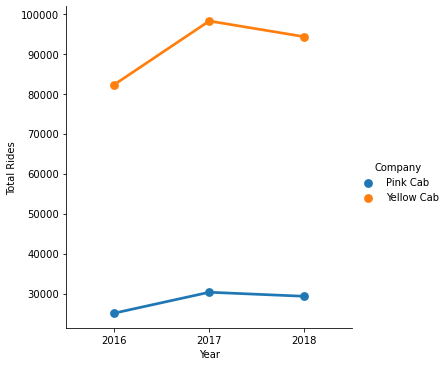

In [86]:
plt.figure(figsize = (8,7))
sns.catplot(x='Date', y='Total Rides', hue='Company', data=number_rides_per_year, kind='point')
#plt.title('Total Rides per year for each company')
plt.xlabel('Year')
plt.show()

The Yellow Cab company has a higher number of trips than Pink Cab. In addition, there is a downward trend in the number of trips in both companies.

In [87]:
number_rides_per_month = df_date.groupby([pd.Grouper(freq="M"), "Company"])['City'].agg(['count'])

In [88]:
number_rides_per_month.reset_index(inplace=True)

In [89]:
number_rides_per_month.rename(columns={'count':'Total Rides'}, inplace=True)

In [90]:
number_rides_per_month.set_index('Date', inplace=True)

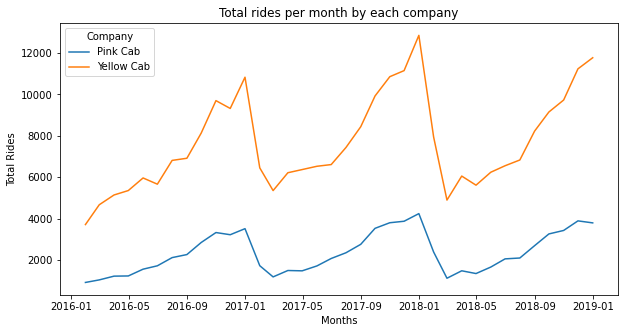

In [91]:
plt.figure(figsize = (10,5))
sns.lineplot(x=number_rides_per_month.index, y='Total Rides', data=number_rides_per_month, hue='Company')

#plt.legend(['Yellow Cab', 'Pink Cab'])
plt.title('Total rides per month by each company')
plt.xlabel('Months')
plt.show()

On a monthly analysis, the highest number of trips for both companies was recorded around the month of January of each year. 

In [92]:
#Customer analysis based on ride distance
df.head()

,City,Population,Users,Date,Holiday,Company,KM Travelled,Price Charged,Cost of Trip,Payment_Mode,Gender,Age,Income (USD/Month),Profit,Margin,Markup
0,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,46.80,1391.91,595.2960,Card,Male,40,11462,796.6140,57.231718,133.818134
1,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,37.12,1238.35,507.8016,Card,Male,34,2589,730.5484,58.993693,143.864927
2,NEW YORK NY,8405837,302149,2016-01-02,NaN,Yellow Cab,38.88,1211.78,517.8816,Cash,Male,45,12186,693.8984,57.262737,133.987846
3,NEW YORK NY,8405837,302149,2016-01-02,NaN,Pink Cab,2.10,37.18,21.4200,Cash,Male,28,15285,15.7600,42.388381,73.576097
4,NEW YORK NY,8405837,302149,2016-01-02,NaN,Pink Cab,32.64,498.60,349.2480,Card,Male,52,15974,149.3520,29.954272,42.763881


In [93]:
km = df[['Company', 'KM Travelled']]

In [94]:
km_bins = [1, 10, 20, 30, 40, 50]
km_names = ['1-10', '11-20', '21-30', '31-40', '41-50']
km['KM Travelled'] = pd.cut(km['KM Travelled'], km_bins, labels=km_names)

<ipython-input-94-04893f86fd08>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  km['KM Travelled'] = pd.cut(km['KM Travelled'], km_bins, labels=km_names)


In [95]:
km_grouped = km.groupby(['Company', 'KM Travelled']).size().reset_index().pivot(columns='Company', values=0, index='KM Travelled')

In [96]:
km_grouped['Total'] = km_grouped['Yellow Cab'] + km_grouped['Pink Cab']

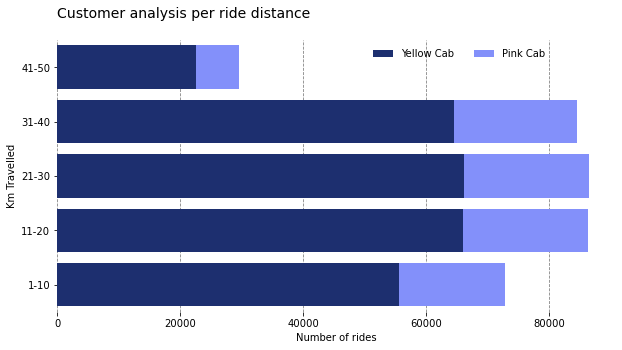

In [97]:
companies = ['Yellow Cab', 'Pink Cab']
colors = ['#1D2F6F', '#8390FA']
labels = ['Yellow Cab', 'Pink Cab']

fig, ax = plt.subplots(1, figsize=(10, 5))

left = len(km_grouped) * [0]
for idx, name in enumerate(companies):
    plt.barh(km_grouped.index, km_grouped[name], left = left, color=colors[idx])
    left = left + km_grouped[name]
    
plt.title('Customer analysis per ride distance\n', loc='left', color='black', fontsize=14)
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Number of rides')
plt.ylabel('Km Travelled')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.show()

There is a clear predominance of medium-distance travel dominated by Yellow Cab

In [98]:
km2 = df[['Company', 'KM Travelled', 'Profit']]

In [99]:
km2['KM Travelled'] = pd.cut(km2['KM Travelled'], km_bins, labels=km_names)

<ipython-input-99-0546fd6019b6>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  km2['KM Travelled'] = pd.cut(km2['KM Travelled'], km_bins, labels=km_names)


In [100]:
km2_grouped = km2.groupby(['Company', 'KM Travelled'])['Profit'].mean().reset_index().pivot(columns='Company', values='Profit', index='KM Travelled')

In [101]:
km2_grouped['Total Profit'] = km2_grouped['Yellow Cab'] + km2_grouped['Pink Cab']

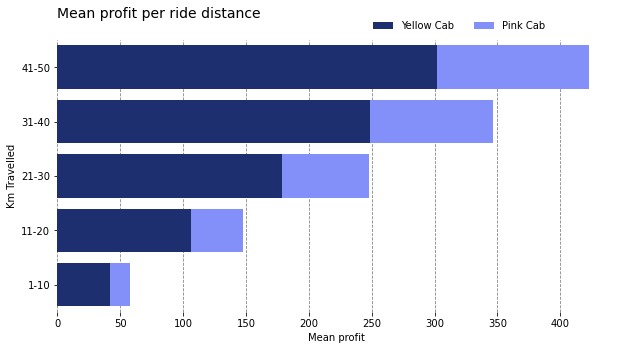

In [102]:
companies = ['Yellow Cab', 'Pink Cab']
colors = ['#1D2F6F', '#8390FA']
labels = ['Yellow Cab', 'Pink Cab']

fig, ax = plt.subplots(1, figsize=(10, 5))

left = len(km2_grouped) * [0]
for idx, name in enumerate(companies):
    plt.barh(km2_grouped.index, km2_grouped[name], left = left, color=colors[idx])
    left = left + km2_grouped[name]
    
plt.title('Mean profit per ride distance\n', loc='left', color='black', fontsize=14)
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Mean profit')
plt.ylabel('Km Travelled')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.show()

The majority of Yellow Cab's revenue comes from medium and long distance travel. Since this company has a large number of medium distance trips, it follows that it outperforms Pink Cab.

In [116]:
#KM travelled and profit
km3 = km2.groupby(['Company', 'KM Travelled'])['Profit'].mean().reset_index()
km3.head()

,Company,KM Travelled,Profit
0,Pink Cab,1-10,16.234503
1,Pink Cab,11-20,41.417432
2,Pink Cab,21-30,68.783371
3,Pink Cab,31-40,97.908523
4,Pink Cab,41-50,120.640453


<AxesSubplot:xlabel='KM Travelled', ylabel='Profit'>

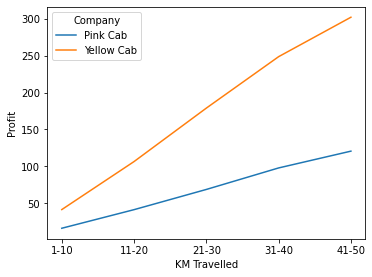

In [117]:
sns.lineplot(x='KM Travelled', y='Profit', hue='Company', data=km3)
plt.xlabel('Mean Profit')

### Costs per rides kilometers

In [118]:
km4 = df[['Company', 'KM Travelled', 'Cost of Trip']]

In [119]:
km4_grouped = km4.groupby(['Company', 'KM Travelled'])['Cost of Trip'].mean().reset_index()

<AxesSubplot:xlabel='KM Travelled', ylabel='Cost of Trip'>

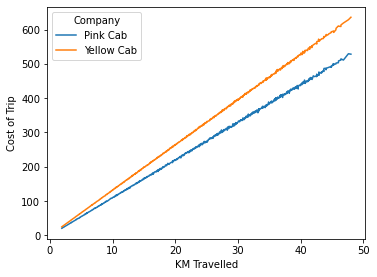

In [120]:
sns.lineplot(x='KM Travelled', y='Cost of Trip', hue='Company', data=km4_grouped)

### Holidays analysis

In [105]:
holiday = df.dropna()

In [106]:
holiday_grouped = holiday.groupby(['Company', 'Holiday']).size().reset_index().pivot(columns='Company', index='Holiday', values=0)

In [107]:
holiday_grouped['Total'] = holiday_grouped['Yellow Cab'] + holiday_grouped['Pink Cab']
holiday_grouped_sorted = holiday_grouped.sort_values(by='Total', ascending=True)
holiday_grouped_sorted.isna().sum()

Company
Pink Cab      0
Yellow Cab    0
Total         0
dtype: int64

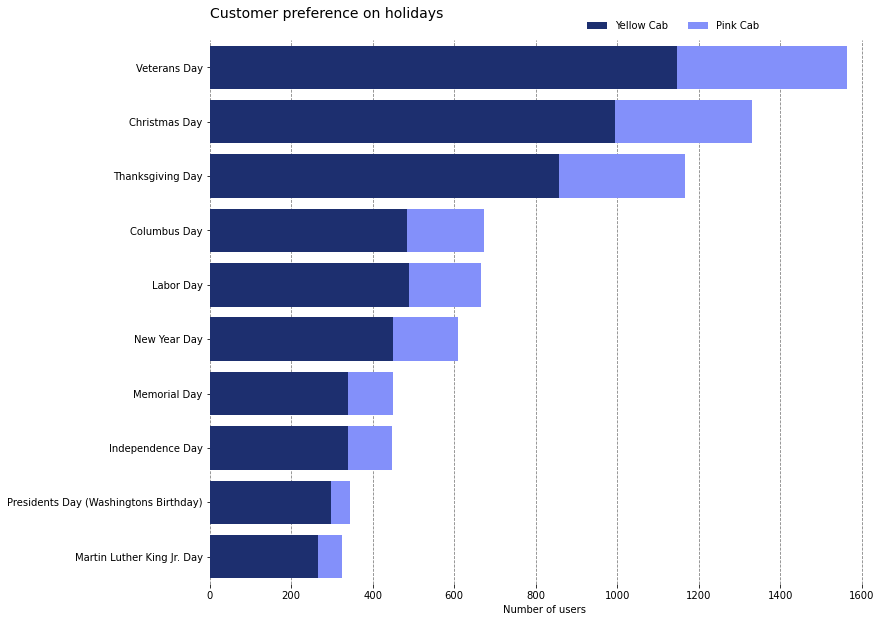

In [108]:
companies = ['Yellow Cab', 'Pink Cab']
colors = ['#1D2F6F', '#8390FA']
labels = ['Yellow Cab', 'Pink Cab']

fig, ax = plt.subplots(1, figsize=(12, 10))

left = len(holiday_grouped_sorted) * [0]
for idx, name in enumerate(companies):
    plt.barh(holiday_grouped_sorted.index, holiday_grouped_sorted[name], left = left, color=colors[idx])
    left = left + holiday_grouped_sorted[name]
    
plt.title('Customer preference on holidays\n', loc='left', color='black', fontsize=14)
plt.legend(labels, bbox_to_anchor=([0.55, 1, 0, 0]), ncol=4, frameon=False)
plt.xlabel('Number of users')

ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_visible(False)

plt.ylim(-0.5, ax.get_yticks()[-1] + 0.5)
ax.set_axisbelow(True)
ax.xaxis.grid(color='gray', linestyle='dashed')

plt.show()

# Conclusions

From the above analysis we can say that there is a seasonality in the number of customers in a given period of time (months). This seasonality indicates that Yellow Cab has more clients than Pink Cab in the whole period analyzed. In addition, there is a seasonality in the profit of each company, with a downward trend. Yellow Cab dominates the market over Pink Cab, even on holidays, when users prefer to use Yellow Cab services. Therefore, based on the above, we can suggest that the best company to invest in is Yellow Cab. This investment will surely have a positive influence on its performance and, by increasing its fleet, it will be able to modify the trend observed in the last few years.